In [ ]:
#download .m4a audio file from youtube link

import youtube_dl

options = {
  'format': 'bestaudio/best',
  'extractaudio' : True,  # only keep the audio
  'audioformat' : "m4a",  # convert to mp3 
  'outtmpl': '%(id)s.m4a',    # name the file the ID of the video
  'noplaylist' : True,    # only download single song, not playlist
}

with youtube_dl.YoutubeDL(options) as ydl:
    ydl.download(['https://www.youtube.com/watch?v=5OLzuUVfoJ8&list=PLU4QInDhN7ml1e2LAIGBaGo01aYZ4kzEQ'])

#convert .m4a to .wav file using ffmpeg
#ffmpeg -i 5OLzuUVfoJ8.m4a 5OLzuUVfoJ8.wav
#need way to automate this by calling cmd line with the above script


22050


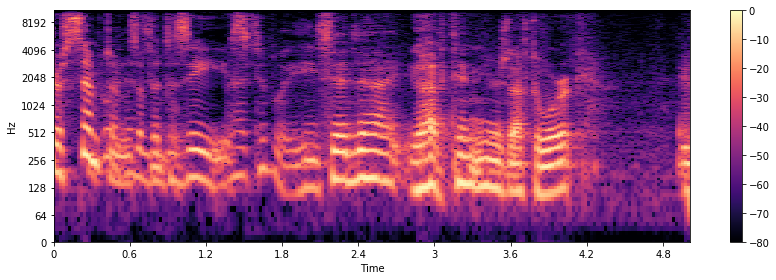

In [54]:
#viewing full spectrogram of .wav file
import numpy as np
import matplotlib.pyplot as plt
import librosa

import librosa.display

y, sr = librosa.load('5OLzuUVfoJ8.wav', duration=120)

# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

idx = slice(*librosa.time_to_frames([30, 35], sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

In [26]:
#filter out background noise to 'clean' the audio file to have just voices
S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full


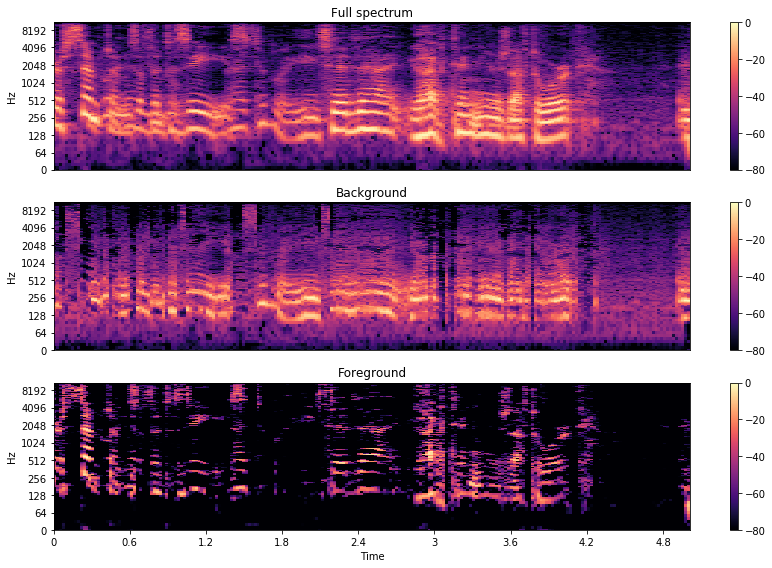

In [27]:

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [69]:
#write out wav file of just foregroud of recording
D_foreground = S_full * phase
y_foreground = librosa.istft(D_foreground)
librosa.output.write_wav('foremaybe.wav', y_foreground, sr)




In [ ]:
#Next Steps, find way to idetentify who is speaking and when, so I can extract just that bit 
#of audio to use as analysis
#Could potentially use nueral net to automatically detect who is speaking?
